In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import pickle
#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
path_extracted_data = config.path_extracted_data
id_run = config.id_run
path_extracted_data_adap = os.path.join(path_extracted_data,'Adaptability')
print(id_run)

ALLDATA_


# Download data

In [4]:
#data used in random regression model
df = pd.read_csv(os.path.join(path_extracted_data_adap,'df_MVT_4individuality_withPCA.csv'), sep=',')
print(df.shape)
display(df.head(3))

(3230, 26)


,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,nbr_stays_5_Zone_perh,nbr_stays_1_Zone_perh,in_WG_15mnAfterOpening,SleepingHeight,vertical_travel_distance_perh,DIB_startat11,avgDIB,severity,Feathers,PC1
0,hen_134,11,MEXP,pen10,11.500000,1,1112,TRAN,100,0,...,0.1,0.0,0,3,0.0,0,22.357143,34,73.0,-1.738433
1,hen_134,12,MEXP,pen10,10.166667,0,1112,TRAN,86,0,...,0.2,0.0,0,3,0.6,1,22.357143,34,73.0,-1.455477
2,hen_134,13,MEXP,pen10,9.000000,0,1112,TRAN,100,0,...,0.1,0.0,0,3,0.0,2,22.357143,34,73.0,-1.738433


In [5]:
#download predictability estimates
df_pred = pd.read_csv(os.path.join(path_extracted_data_adap,'BLUPS_variability0_pred.csv'), sep=',')
print(df_pred.shape) #2500 samples of 336*10 chains parameters
display(df_pred.head(3))
print(list(df_pred.columns))
#sd_HenID__sigma_Intercept: is the estimate for individual differences in residual variance
#b_sigma_Intercept: is the population level estimate of the residual variance
#sigma: residual part of the variance. cf hertel for more detail
li_col = [x for x in df_pred.columns if 'r_HenID__sigma' in x]
df_pred = df_pred[li_col]
display(df_pred.head(3))

#melt data for simplicity
df_pred['run'] = df_pred.index
df_pred = pd.melt(df_pred, id_vars=['run'], value_vars=li_col)
df_pred['HenID'] = df_pred['variable'].map(lambda x: x.split('r_HenID__sigma.')[1].split('.')[0])
#"Importantly, in order to assess whether individuals differ in variance the residual part of the model iscalculated on the log 
#scale! In order to interpret rIIV in biological terms we backtransform rIIV by takingit’s original scale by taking its exponent"
df_pred['Variability'] = df_pred['value'].map(lambda x: np.exp(x))
df_pred['Predictability'] = df_pred['Variability'].map(lambda x: x*(-1))
print(df_pred.shape)
df_pred.head(3)

#predictability
df_pred_summarized = df_pred.groupby('HenID')[['Predictability','Variability']].agg(lambda x: list(x)).reset_index()
df_pred_summarized['Predictability_mean'] = df_pred_summarized['Predictability'].map(lambda x: np.mean(x))
df_pred_summarized['Predictability_sd'] = df_pred_summarized['Predictability'].map(lambda x: np.std(x))

df_pred_summarized['Variability_mean'] = df_pred_summarized['Variability'].map(lambda x: np.mean(x))
df_pred_summarized['Variability_sd'] = df_pred_summarized['Variability'].map(lambda x: np.std(x))
print(df_pred_summarized.shape)
df_pred_summarized.head(3)

(8334, 3410)


,X1.b_Intercept,X1.b_sigma_Intercept,X1.b_time,X1.b_time2,X1.b_TreatmentOFH,X1.b_temperature_C_avg_scale,X1.b_sigma_time,X1.b_sigma_time2,X1.b_sigma_TreatmentOFH,X1.b_sigma_temperature_C_avg_scale,...,X10.r_HenID__sigma.hen_85.Intercept.,X10.r_HenID__sigma.hen_87.Intercept.,X10.r_HenID__sigma.hen_9.Intercept.,X10.r_HenID__sigma.hen_90.Intercept.,X10.r_HenID__sigma.hen_92.Intercept.,X10.r_HenID__sigma.hen_95.Intercept.,X10.r_HenID__sigma.hen_97.Intercept.,X10.r_HenID__sigma.hen_98.Intercept.,X10.r_HenID__sigma.hen_99.Intercept.,X10.lp__
0,-0.487604,-0.402776,0.973027,-0.241320,-0.349758,-0.051588,-0.018391,-0.071007,-0.058844,0.028033,...,-0.045018,0.278245,-0.188997,0.266686,0.109263,-0.401039,-0.073058,0.106159,-0.275771,-2503.749454
1,-0.585886,-0.414933,1.072083,-0.240398,-0.288871,-0.054558,-0.049464,-0.056232,-0.126719,0.036610,...,0.291800,0.220126,-0.056462,0.120657,0.063677,-0.130329,0.011630,0.072115,-0.071715,-2554.223671
2,-0.344724,-0.352599,1.010160,-0.235717,-0.539759,-0.026497,-0.125561,-0.038701,-0.141354,0.060235,...,0.044993,0.166598,-0.325361,-0.003502,0.117427,-0.157880,-0.425598,0.083381,0.044226,-2550.531880


['X1.b_Intercept', 'X1.b_sigma_Intercept', 'X1.b_time', 'X1.b_time2', 'X1.b_TreatmentOFH', 'X1.b_temperature_C_avg_scale', 'X1.b_sigma_time', 'X1.b_sigma_time2', 'X1.b_sigma_TreatmentOFH', 'X1.b_sigma_temperature_C_avg_scale', 'X1.sd_HenID__Intercept', 'X1.sd_HenID__time', 'X1.sd_HenID__time2', 'X1.sd_HenID__sigma_Intercept', 'X1.cor_HenID__Intercept__time', 'X1.cor_HenID__Intercept__time2', 'X1.cor_HenID__time__time2', 'X1.cor_HenID__Intercept__sigma_Intercept', 'X1.cor_HenID__time__sigma_Intercept', 'X1.cor_HenID__time2__sigma_Intercept', 'X1.r_HenID.hen_10.Intercept.', 'X1.r_HenID.hen_101.Intercept.', 'X1.r_HenID.hen_102.Intercept.', 'X1.r_HenID.hen_106.Intercept.', 'X1.r_HenID.hen_107.Intercept.', 'X1.r_HenID.hen_109.Intercept.', 'X1.r_HenID.hen_112.Intercept.', 'X1.r_HenID.hen_116.Intercept.', 'X1.r_HenID.hen_118.Intercept.', 'X1.r_HenID.hen_119.Intercept.', 'X1.r_HenID.hen_124.Intercept.', 'X1.r_HenID.hen_127.Intercept.', 'X1.r_HenID.hen_128.Intercept.', 'X1.r_HenID.hen_13.Interc

,X1.r_HenID__sigma.hen_10.Intercept.,X1.r_HenID__sigma.hen_101.Intercept.,X1.r_HenID__sigma.hen_102.Intercept.,X1.r_HenID__sigma.hen_106.Intercept.,X1.r_HenID__sigma.hen_107.Intercept.,X1.r_HenID__sigma.hen_109.Intercept.,X1.r_HenID__sigma.hen_112.Intercept.,X1.r_HenID__sigma.hen_116.Intercept.,X1.r_HenID__sigma.hen_118.Intercept.,X1.r_HenID__sigma.hen_119.Intercept.,...,X10.r_HenID__sigma.hen_84.Intercept.,X10.r_HenID__sigma.hen_85.Intercept.,X10.r_HenID__sigma.hen_87.Intercept.,X10.r_HenID__sigma.hen_9.Intercept.,X10.r_HenID__sigma.hen_90.Intercept.,X10.r_HenID__sigma.hen_92.Intercept.,X10.r_HenID__sigma.hen_95.Intercept.,X10.r_HenID__sigma.hen_97.Intercept.,X10.r_HenID__sigma.hen_98.Intercept.,X10.r_HenID__sigma.hen_99.Intercept.
0,0.017452,0.115267,-0.220349,0.412432,0.321030,0.468429,-0.086234,-0.176554,-0.010539,0.039291,...,0.200185,-0.045018,0.278245,-0.188997,0.266686,0.109263,-0.401039,-0.073058,0.106159,-0.275771
1,0.181898,0.429418,-0.475571,0.429450,0.469265,0.681417,0.032378,-0.255249,0.146933,0.038215,...,0.137123,0.291800,0.220126,-0.056462,0.120657,0.063677,-0.130329,0.011630,0.072115,-0.071715
2,0.171663,0.294926,-0.331497,0.418552,0.399949,0.657787,0.073380,-0.038833,0.151138,0.213504,...,0.076867,0.044993,0.166598,-0.325361,-0.003502,0.117427,-0.157880,-0.425598,0.083381,0.044226


(6667200, 6)
(80, 7)


,HenID,Predictability,Variability,Predictability_mean,Predictability_sd,Variability_mean,Variability_sd
0,hen_10,"[-1.0176055718243788, -1.1994922607609264, -1....","[1.0176055718243788, 1.1994922607609264, 1.187...",-1.038280,0.112738,1.038280,0.112738
1,hen_101,"[-1.1221725672194474, -1.5363625570416004, -1....","[1.1221725672194474, 1.5363625570416004, 1.343...",-1.361887,0.156616,1.361887,0.156616
2,hen_102,"[-0.8022388204168472, -0.6215303576634553, -0....","[0.8022388204168472, 0.6215303576634553, 0.717...",-0.635288,0.078090,0.635288,0.078090


In [6]:
df_pred = pd.read_csv(os.path.join(path_extracted_data_adap,'BLUPS_variability0_pred.csv'), sep=',')
print(df_pred.shape) #2500 samples of 336*10 chains parameters
display(df_pred.head(3))
print(list(df_pred.columns))

(8334, 3410)


,X1.b_Intercept,X1.b_sigma_Intercept,X1.b_time,X1.b_time2,X1.b_TreatmentOFH,X1.b_temperature_C_avg_scale,X1.b_sigma_time,X1.b_sigma_time2,X1.b_sigma_TreatmentOFH,X1.b_sigma_temperature_C_avg_scale,...,X10.r_HenID__sigma.hen_85.Intercept.,X10.r_HenID__sigma.hen_87.Intercept.,X10.r_HenID__sigma.hen_9.Intercept.,X10.r_HenID__sigma.hen_90.Intercept.,X10.r_HenID__sigma.hen_92.Intercept.,X10.r_HenID__sigma.hen_95.Intercept.,X10.r_HenID__sigma.hen_97.Intercept.,X10.r_HenID__sigma.hen_98.Intercept.,X10.r_HenID__sigma.hen_99.Intercept.,X10.lp__
0,-0.487604,-0.402776,0.973027,-0.241320,-0.349758,-0.051588,-0.018391,-0.071007,-0.058844,0.028033,...,-0.045018,0.278245,-0.188997,0.266686,0.109263,-0.401039,-0.073058,0.106159,-0.275771,-2503.749454
1,-0.585886,-0.414933,1.072083,-0.240398,-0.288871,-0.054558,-0.049464,-0.056232,-0.126719,0.036610,...,0.291800,0.220126,-0.056462,0.120657,0.063677,-0.130329,0.011630,0.072115,-0.071715,-2554.223671
2,-0.344724,-0.352599,1.010160,-0.235717,-0.539759,-0.026497,-0.125561,-0.038701,-0.141354,0.060235,...,0.044993,0.166598,-0.325361,-0.003502,0.117427,-0.157880,-0.425598,0.083381,0.044226,-2550.531880


['X1.b_Intercept', 'X1.b_sigma_Intercept', 'X1.b_time', 'X1.b_time2', 'X1.b_TreatmentOFH', 'X1.b_temperature_C_avg_scale', 'X1.b_sigma_time', 'X1.b_sigma_time2', 'X1.b_sigma_TreatmentOFH', 'X1.b_sigma_temperature_C_avg_scale', 'X1.sd_HenID__Intercept', 'X1.sd_HenID__time', 'X1.sd_HenID__time2', 'X1.sd_HenID__sigma_Intercept', 'X1.cor_HenID__Intercept__time', 'X1.cor_HenID__Intercept__time2', 'X1.cor_HenID__time__time2', 'X1.cor_HenID__Intercept__sigma_Intercept', 'X1.cor_HenID__time__sigma_Intercept', 'X1.cor_HenID__time2__sigma_Intercept', 'X1.r_HenID.hen_10.Intercept.', 'X1.r_HenID.hen_101.Intercept.', 'X1.r_HenID.hen_102.Intercept.', 'X1.r_HenID.hen_106.Intercept.', 'X1.r_HenID.hen_107.Intercept.', 'X1.r_HenID.hen_109.Intercept.', 'X1.r_HenID.hen_112.Intercept.', 'X1.r_HenID.hen_116.Intercept.', 'X1.r_HenID.hen_118.Intercept.', 'X1.r_HenID.hen_119.Intercept.', 'X1.r_HenID.hen_124.Intercept.', 'X1.r_HenID.hen_127.Intercept.', 'X1.r_HenID.hen_128.Intercept.', 'X1.r_HenID.hen_13.Interc

In [7]:
#MVT since begining: to add info on the first week
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_adap, 'li_selected_hens.pkl'), 'rb'))
print(len(li_selected_hens))
df_MVT_ALL = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';', 
                     parse_dates=['level'], dayfirst=True) 
print(df_MVT_ALL.shape)
df_MVT_ALL = df_MVT_ALL[df_MVT_ALL['HenID'].isin(li_selected_hens)]
#restrict to the adaptability study timeframe
df_MVT_ALL = df_MVT_ALL[df_MVT_ALL['level']<=config.max_date_adaptability]
print(df_MVT_ALL.shape)
#make sure we have their mvt
df_MVT_ALL = df_MVT_ALL[~df_MVT_ALL['perc_duration_5_Zone'].isnull()]
print(df_MVT_ALL.shape)
df_MVT_ALL.head(3)

80
(42300, 63)
(3750, 63)
(3750, 63)


,HenID,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,Treatment,level,DIB,...,percChaoticTransition,night_Max_duration_zones,is_mvt_night,empproba_3_Zone,empproba_4_Zone,empproba_2_Zone,in_WG_15mnAfterOpening,Max_duration_WG_h,perc_1_Zone_while_WG_open,SleepingHeight
114,hen_134,pen10,MEXP,tag_122,22black,4.0,2020-06-10 00:00:00,TRAN,2020-09-30,1,...,18.0,5_Zone,0.0,80.0,20.0,100.0,NaN,NaN,NaN,3
115,hen_134,pen10,MEXP,tag_122,22black,4.0,2020-06-10 00:00:00,TRAN,2020-10-01,2,...,0.0,5_Zone,0.0,0.0,0.0,0.0,NaN,NaN,NaN,3
116,hen_134,pen10,MEXP,tag_122,22black,4.0,2020-06-10 00:00:00,TRAN,2020-10-02,3,...,0.0,3_Zone,1.0,50.0,25.0,100.0,NaN,NaN,NaN,1


# Add nbr days within first three without mvt

In [8]:
m = df_MVT_ALL['DIB'].min()
print(m)
df_nomvt = df_MVT_ALL[df_MVT_ALL['DIB'].isin([m,m+1,m+2])].groupby('HenID')[['Total_number_zone']].agg(lambda x: list(x)).reset_index()
df_nomvt['nbr_daysnomvt_over_3days'] = df_nomvt['Total_number_zone'].agg(lambda x: sum([i==1 for i in x]))
print(df_nomvt.shape)
display(df_nomvt.head(3))
df_all = pd.merge(df, df_nomvt[['HenID','nbr_daysnomvt_over_3days']],  on='HenID', how='left')
print(df_all.shape)
df_all.head(3)

1
(80, 3)


,HenID,Total_number_zone,nbr_daysnomvt_over_3days
0,hen_10,"[4.0, 2.0, 1.0]",1
1,hen_101,"[2.0, 2.0, 3.0]",0
2,hen_102,"[4.0, 1.0, 1.0]",2


(3230, 27)


,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,nbr_stays_1_Zone_perh,in_WG_15mnAfterOpening,SleepingHeight,vertical_travel_distance_perh,DIB_startat11,avgDIB,severity,Feathers,PC1,nbr_daysnomvt_over_3days
0,hen_134,11,MEXP,pen10,11.500000,1,1112,TRAN,100,0,...,0.0,0,3,0.0,0,22.357143,34,73.0,-1.738433,1
1,hen_134,12,MEXP,pen10,10.166667,0,1112,TRAN,86,0,...,0.0,0,3,0.6,1,22.357143,34,73.0,-1.455477,1
2,hen_134,13,MEXP,pen10,9.000000,0,1112,TRAN,100,0,...,0.0,0,3,0.0,2,22.357143,34,73.0,-1.738433,1


In [9]:
#small check: 80 animasl * 3 days
if df_MVT_ALL[df_MVT_ALL['DIB'].isin([m,m+1,m+2])].shape[0]!=80*3:
    print('ERROR:missing important data!')
    sys.exit()
print('In total %s day-hen without transitions'%sum(df_nomvt['nbr_daysnomvt_over_3days']))
df_ = df_MVT_ALL[df_MVT_ALL['DIB'].isin([m,m+1,m+2])]
df_['fuldDayZone5'] = df_['perc_duration_5_Zone'].map(lambda x: x==100)
df_['fuldDayZone5'].value_counts()

In total 45 day-hen without transitions


C:\Users\camil\AppData\Local\Temp/ipykernel_12680/2981952583.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['fuldDayZone5'] = df_['perc_duration_5_Zone'].map(lambda x: x==100)


False    195
True      45
Name: fuldDayZone5, dtype: int64

# Add predictability estimates

In [10]:
print(df_all.shape)
df_all = pd.merge(df_all, df_pred_summarized[['HenID','Predictability_mean','Predictability_sd','Variability_mean','Variability_sd']],  on='HenID', how='left')
print(df_all.shape)
df_all.head(5)

(3230, 27)
(3230, 31)


,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,DIB_startat11,avgDIB,severity,Feathers,PC1,nbr_daysnomvt_over_3days,Predictability_mean,Predictability_sd,Variability_mean,Variability_sd
0,hen_134,11,MEXP,pen10,11.500000,1,1112,TRAN,100,0,...,0,22.357143,34,73.0,-1.738433,1,-0.86939,0.097638,0.86939,0.097638
1,hen_134,12,MEXP,pen10,10.166667,0,1112,TRAN,86,0,...,1,22.357143,34,73.0,-1.455477,1,-0.86939,0.097638,0.86939,0.097638
2,hen_134,13,MEXP,pen10,9.000000,0,1112,TRAN,100,0,...,2,22.357143,34,73.0,-1.738433,1,-0.86939,0.097638,0.86939,0.097638
3,hen_134,16,MEXP,pen10,7.833333,1,1112,TRAN,88,1,...,5,22.357143,34,73.0,-1.476247,1,-0.86939,0.097638,0.86939,0.097638
4,hen_134,17,MEXP,pen10,10.500000,0,1112,TRAN,98,0,...,6,22.357143,34,73.0,-1.644616,1,-0.86939,0.097638,0.86939,0.097638


In [11]:
df_all.to_csv(os.path.join(path_extracted_data_adap,'df_MVT_4stat_BI.csv'), index=False, sep=';')

# Visuals

In [12]:
print(df_all.shape)
df_all.head(3)

(3230, 31)


,HenID,DIB,CLASS,PenID,temperature_C_avg,tobeusedPCA,InitialWeight,Treatment,perc_duration_5_Zone,perc_duration_4_Zone,...,DIB_startat11,avgDIB,severity,Feathers,PC1,nbr_daysnomvt_over_3days,Predictability_mean,Predictability_sd,Variability_mean,Variability_sd
0,hen_134,11,MEXP,pen10,11.500000,1,1112,TRAN,100,0,...,0,22.357143,34,73.0,-1.738433,1,-0.86939,0.097638,0.86939,0.097638
1,hen_134,12,MEXP,pen10,10.166667,0,1112,TRAN,86,0,...,1,22.357143,34,73.0,-1.455477,1,-0.86939,0.097638,0.86939,0.097638
2,hen_134,13,MEXP,pen10,9.000000,0,1112,TRAN,100,0,...,2,22.357143,34,73.0,-1.738433,1,-0.86939,0.097638,0.86939,0.097638


(80, 5)


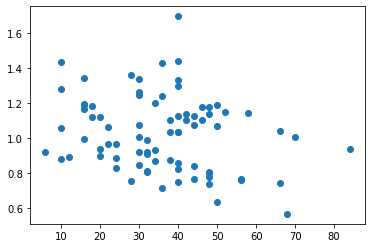

In [13]:
df_plt = df_all[['HenID','Variability_mean','severity','Feathers','nbr_daysnomvt_over_3days']].drop_duplicates().copy()
print(df_plt.shape)
plt.scatter(df_plt['severity'], df_plt['Variability_mean']);

(80, 5)


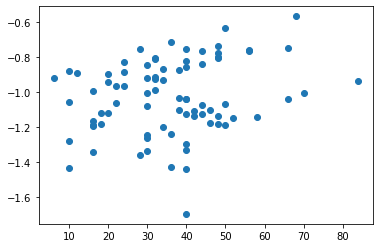

In [14]:
df_plt = df_all[['HenID','Predictability_mean','severity','Feathers','nbr_daysnomvt_over_3days']].drop_duplicates().copy()
print(df_plt.shape)
plt.scatter(df_plt['severity'], df_plt['Predictability_mean']);

C:\Users\camil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


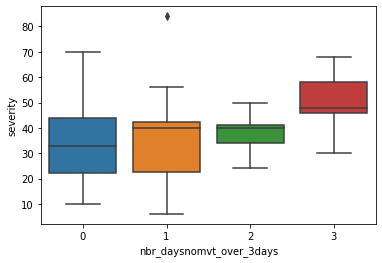

In [15]:
sns.boxplot('nbr_daysnomvt_over_3days','severity', data=df_plt);

In [15]:
df_plt['nbr_daysnomvt_over_3days'].value_counts()

0    52
1    16
2     7
3     5
Name: nbr_daysnomvt_over_3days, dtype: int64